In [2]:
pip install matplotlib numpy pandas


The following command must be run outside of the IPython shell:

    $ pip install matplotlib numpy pandas

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

q3 = ['2019-01-01', '2019-03-31'] #2019-01-01 through 2019-03-31
q4 = ['2019-04-01', '2019-06-30'] #2019-04-01 through 2019-06-30
q1 = ['2019-07-01', '2019-09-30'] #2019-07-01 through 2019-09-30
q2 = ['2019-10-01', '2019-12-31'] #2019-10-01 through 2019-12-31

def print_basic_stats( jobs_df, workflow_df, resumes_df ):
    workflow_count = len(jobs_df['dag_id'].unique())
    print( f"Total number of workflows: {workflow_count}")
    
    successful_job_count = len(jobs_df.loc[jobs_df['status']=='D'])
    print( f"Total number of successful jobs: {successful_job_count}")
    
    earliest_status_date = workflow_df['status_date'].min()
    print( f"Earliest workflow status date: {earliest_status_date}")
    
    last_status_date = workflow_df['status_date'].max()
    print( f"Last workflow status date: {last_status_date}")
    
    max_job_count = workflow_df['number_of_jobs'].max()
    print( f"Max number of jobs in workflow: {max_job_count}")
    
    done_df = workflow_df.loc[(workflow_df['status']=='D')]
    median_job_count = done_df['number_of_jobs'].median()
    print( f"Median number of jobs in workflow: {median_job_count}")
    
    retried_df = jobs_df.loc[(jobs_df['status']=='D') & (jobs_df['num_attempts'] > 1)]
    immediate_df = jobs_df.loc[(jobs_df['status']=='D') & (jobs_df['num_attempts'] == 1)]
    print( "Immediate shape {i}, retry shape {r}".format(i=immediate_df.shape, r=retried_df.shape))
    # The following code not good due to bad data pull.
    # workflowids and workflow_run_ids not unique across databases.
    # Was not used in the paper
#     good_df=resumes_df.loc[resumes_df['w_status']=='D']
#     good_df['unique-key']=good_df['database'].astype(str) + "_" + good_df['w_id'].astype(str)

def plot_workflow_sizes( workflow_df ):
    """Bucket the workflows by number of jobs, too inefficient for millions of jobs"""
    job_counts = workflow_df['number_of_jobs']
    plt.hist(job_counts, bins=100)
    plt.ylabel('Counts')
    plt.title('Jobs per workflow')
    
def plot_retry_rates( jobs_df ):
    """Bucket number of retries"""
    done_jobs_after_retry = jobs_df.loc[(jobs_df['status']=='D') & (jobs_df['num_attempts'] > 1)]
    attempts = done_jobs_after_retry['num_attempts']
    plt.hist(attempts, bins=30)
    plt.ylabel('Counts')
    plt.title('#Attempts for Jobs that suceeded after the 1st attempt')
    
def plot_retry_rates_per_month( jobs_df ):
    """Plot %-rate of retries per month"""
    jobs_df['year'] = jobs_df['date'].dt.year
    jobs_df['month'] = jobs_df['date'].dt.month
    jobs_df['month_index'] = (jobs_df['year']-2018)*12 + jobs_df['month'] -7
    retried_df = jobs_df.loc[(jobs_df['status']=='D') & (jobs_df['num_attempts'] > 1)]
    g_retried_df = retried_df.groupby(['month_index']).count()[['num_attempts']]
    immediate_df = jobs_df.loc[(jobs_df['status']=='D') & (jobs_df['num_attempts'] == 1)]
    g_immediate_df = immediate_df.groupby(['month_index']).count()[['num_attempts']]
    merge_df = g_immediate_df.join(g_retried_df, lsuffix='_immediate', rsuffix='_retried')
    merge_df['rate'] = 100 * merge_df['num_attempts_retried'] / merge_df['num_attempts_immediate']   
    rate_df = merge_df['rate']
    
    total_retries = retried_df.count()[['num_attempts']]
    total_immediate = immediate_df.count()[['num_attempts']]
    
    r,_ = retried_df.shape
    i,_= immediate_df.shape
    percentage = (100*r)/i
    print( f"Overall Percentage retry rate {percentage}")
    
    print('Calculations complete')

    fig, ax = plt.subplots()
    plt.plot(rate_df, color="black")
    plt.ylabel('%-Rate')
    plt.xlabel('Month')
    ax.set_xticks([x for x in range(12)])
    x_ticks_labels = ['J','A','S','O','N','D','J','F','M','A','M','J']
    ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=14)
    plt.title('Retry %-rate per month from July 2018')
    plt.show()
    
def plot_retries_per_workflow( jobs_df ):
    """Which were the most unreliable workflow? Not useful, abandonded. Currently shows totals, not rate
    For rate, copy the method used in the by-month graph"""
    done_jobs = jobs_df.loc[(jobs_df['status']=='D') & (jobs_df['num_attempts'] > 1)]
    done_by_workflow = done_jobs.groupby(['dag_id']).count()[['num_attempts']]
    
    fig, ax = plt.subplots()
    plt.plot(done_by_workflow, color="black")
    plt.ylabel('%-Rate')
    plt.ylabel('Counts')
    plt.title('Retry Counts by Workflow')
    plt.show()
    
def max_attempts_per_workflow( jobs_df ):
    """Bucket the workflows by number of jobs"""
    done_jobs = jobs_df.loc[(jobs_df['status']=='D') ]
    done_by_workflow = done_jobs.groupby(['dag_id']).max()
    attempts_by_workflow = done_by_workflow['num_attempts']
    plt.hist(attempts_by_workflow, bins=5)
    plt.ylabel('Counts')
    plt.title('Max Attempts Counts by Workflow')
    
def clean_read( name, filepath, status_date_column_name, quarter=None ):
    print( f"Reading {name}")
    df = pd.read_hdf( filepath, key='counts', mode='r')
    df['date'] = pd.to_datetime(df[status_date_column_name])
    if quarter:
        df = df[(df['date'] > quarter[0])&(df['date'] < quarter[1])]
    print( "  {name} columns {c}".format( name=name, c=list(df.columns) ))
    print( "  {name} shape {s}".format(name=name, s=df.shape))
    return df
    
def load(quarter=None):
    root_path = '/Users/mm7148/h/jobmon/statistics/'
    workflow_df = clean_read('workflow', f"{root_path}/stats_workflows.h5", 'status_date', quarter)
    jobs_df = clean_read('jobs', f"{root_path}/stats_jobs.h5", 'status_date', quarter)
    resumes_df = clean_read('resumes', f"{root_path}/stats_resumes.h5", 'wr_status_date', quarter)
    return workflow_df, jobs_df, resumes_df
    

In [ ]:
workflow_df, jobs_df, resumes_df = load(quarter=q4)

Reading jobs


In [1]:
print_basic_stats( jobs_df, workflow_df, resumes_df  )

NameError: name 'print_basic_stats' is not defined

In [73]:
#Too inefficient and not needed
#plot_workflow_sizes( workflow_df )

In [74]:
#Too inefficient and not needed
#plot_retry_rates( jobs_df )

Overall Percentage retry rate 1.6076938604838942
Calculations complete


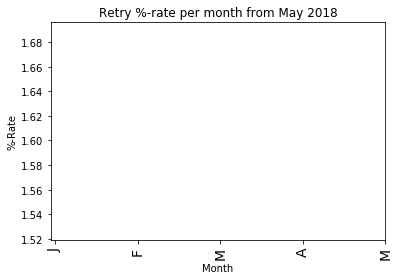

In [75]:
plot_retry_rates_per_month( jobs_df )

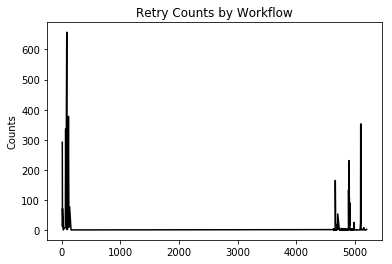

In [76]:
#Not useful, left here as an example
plot_retries_per_workflow( jobs_df )

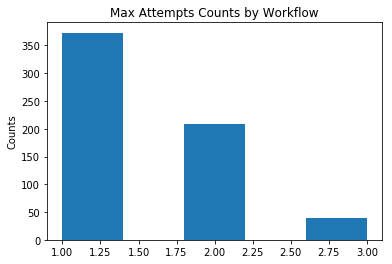

In [77]:
max_attempts_per_workflow( jobs_df )